In [24]:
import pandas as pd
import numpy as np
from io import BytesIO
import datetime
import time
import logging
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from scipy import stats
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, precision_score, recall_score, f1_score, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score, train_test_split
import shap

pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('csv/new_york_listings_2024.csv')

### Exploratory data analysis

In [4]:
df.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                             float64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
number_of_reviews_ltm               int64
license                            object
rating                             object
bedrooms                           object
beds                                int64
baths                              object
dtype: object

In [5]:
df['rating'] = df['rating'].replace('No rating', np.nan).replace('New ', np.nan).astype(float)
df['number_of_reviews'] = df['number_of_reviews'].astype(float)

In [6]:
df.groupby('room_type')\
    .agg({'host_id':'nunique', 
          'id':'nunique', 
          'number_of_reviews':'mean',
          'rating':'mean'})\
    .reset_index()

,room_type,host_id,id,number_of_reviews,rating
0,Entire home/apt,7720,11549,39.534678,4.752060
1,Hotel room,25,112,57.696429,4.540115
2,Private room,5103,8804,46.303839,4.716090
3,Shared room,227,293,49.378840,4.648590


##### Check for Null Values

In [7]:
df.isnull().sum()

id                                   0
name                                 0
host_id                              0
host_name                            0
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                          0
reviews_per_month                    0
calculated_host_listings_count       0
availability_365                     0
number_of_reviews_ltm                0
license                              0
rating                            3752
bedrooms                             0
beds                                 0
baths                                0
dtype: int64

##### Rating has null values for 3.7k records - these will be not be imputed because rating is our target; Null values will be excluded

#### Correlation matrix

In [9]:
# map categorical features with cat.codes
df['neighbourhood_group']= df['neighbourhood_group'].astype("category").cat.codes
df['neighbourhood'] = df['neighbourhood'].astype("category").cat.codes
df['room_type'] = df['room_type'].astype("category").cat.codes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   name                            20758 non-null  object 
 2   host_id                         20758 non-null  int64  
 3   host_name                       20758 non-null  object 
 4   neighbourhood_group             20758 non-null  int8   
 5   neighbourhood                   20758 non-null  int16  
 6   latitude                        20758 non-null  float64
 7   longitude                       20758 non-null  float64
 8   room_type                       20758 non-null  int8   
 9   price                           20758 non-null  float64
 10  minimum_nights                  20758 non-null  int64  
 11  number_of_reviews               20758 non-null  float64
 12  last_review                     

#### Rating distribution

Text(0.5, 1.0, 'Rating Distribution Plot')

<Figure size 500x500 with 0 Axes>

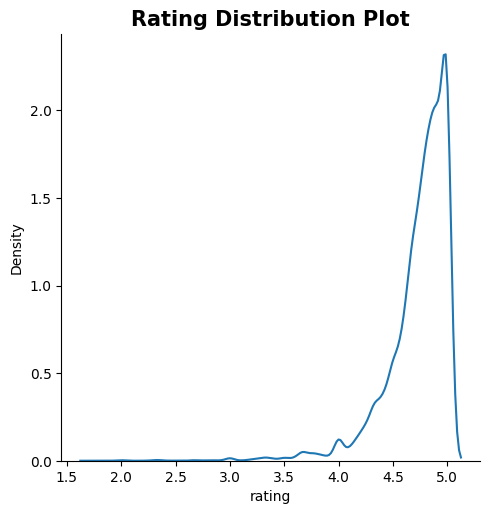

In [20]:
plt.figure(figsize=(5,5))
sns.displot(df['rating'], kind='kde')
plt.title("Rating Distribution Plot",size=15, weight='bold')

Text(0.5, 1.0, 'Log-Rating Distribution Plot')

<Figure size 500x500 with 0 Axes>

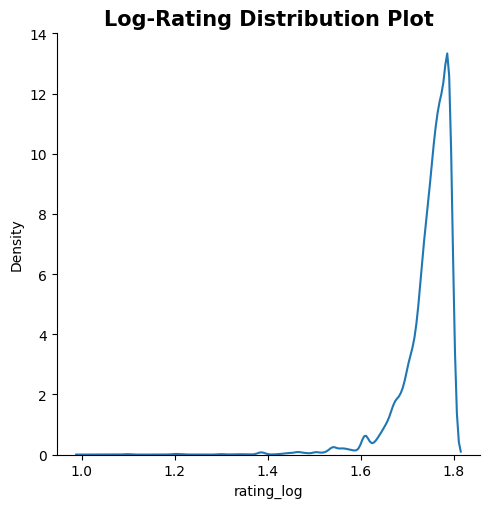

In [22]:
# normalize rating
df['rating_log'] = np.log(df.rating+1)

plt.figure(figsize=(5,5))
sns.displot(df['rating_log'], kind='kde')
plt.title("Log-Rating Distribution Plot",size=15, weight='bold')

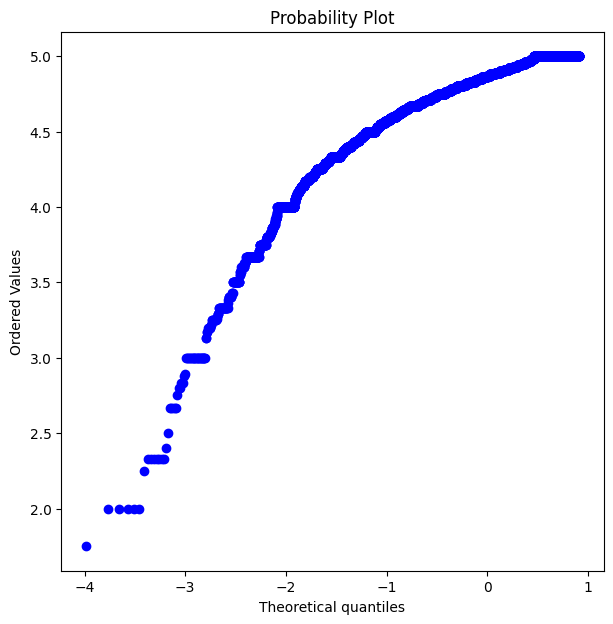

In [26]:
plt.figure(figsize=(7,7))
stats.probplot(df['rating'], plot=plt)
plt.show()

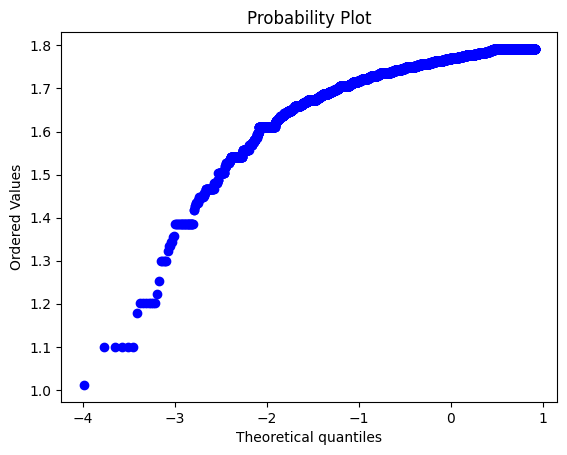

In [27]:
stats.probplot(df['rating_log'], plot=plt)
plt.show()

##### Log-rating does not show more normality, so we can use the raw Rating feature to develop our target

In [34]:
df_feat = df.drop(columns=['name','id' ,'host_id','host_name','last_review','license'])

df_feat['baths'] = df_feat['baths'].replace('Not specified', None)
df_feat['bedrooms'] = df_feat['bedrooms'].replace('Studio', 0.5)

In [35]:
df_feat.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,rating,bedrooms,beds,baths,rating_log
0,1,42,40.683710,-73.964610,2,55.0,30,3.0,0.03,1,0,0,5.00,1,1,None,1.791759
1,2,96,40.766610,-73.988100,0,144.0,30,9.0,0.24,139,364,2,4.67,2,1,1,1.735189
2,2,34,40.750764,-73.994605,0,187.0,2,6.0,1.67,1,343,6,4.17,1,2,1,1.642873
3,2,206,40.835600,-73.942500,2,120.0,30,156.0,1.38,2,363,12,4.64,1,1,1,1.729884
4,2,138,40.751120,-73.978600,0,85.0,30,11.0,0.24,133,335,3,4.91,0.5,1,1,1.776646


Text(0.5, 1.0, 'Correlation Matrix')

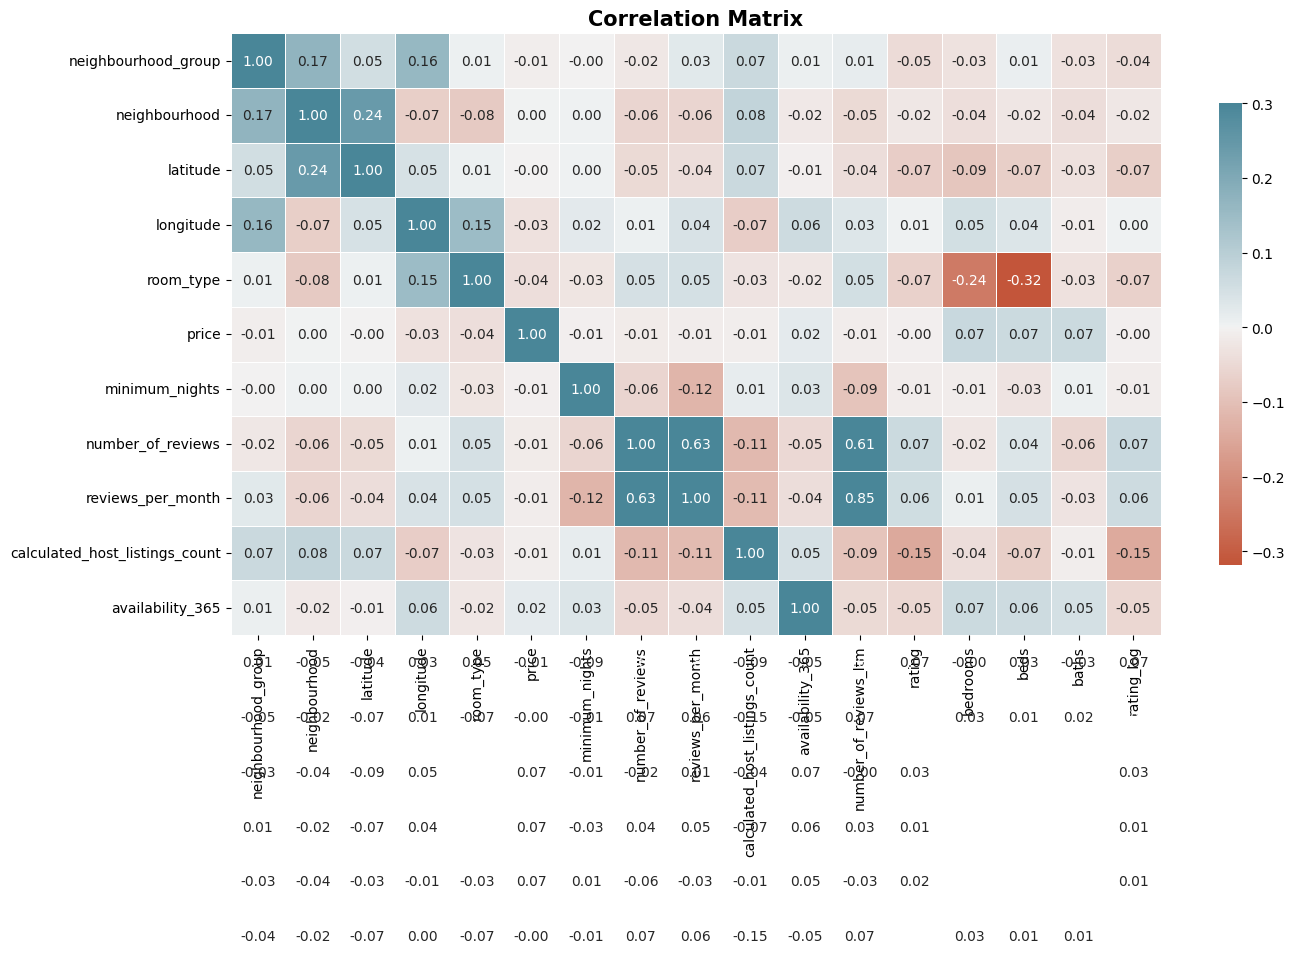

In [36]:
plt.figure(figsize=(15,12))
palette = sns.diverging_palette(20, 220, n=256)
corr = df_feat.corr(method='pearson')
sns.heatmap(corr, annot=True, fmt=".2f", cmap=palette, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set(ylim=(11, 0))
plt.title("Correlation Matrix",size=15, weight='bold')

###### There is not a strong relationship between rating and any of the features

### Create Target

In [41]:
# Predicting if a Airbnb Host is high rated (>= 4.8) based on corresponding listing features
df['rating_gt_four_point_eight'] = np.where(df.rating>=4.8, 1, 0)

df.groupby('rating_gt_four_point_eight')\
    .agg({'host_id':'nunique', 
          'id':'nunique', 
          'number_of_reviews':'mean',
          'rating':'mean'})\
    .rename(columns={'number_of_reviews':'avg_number_of_reviews', 
                     'rating':'avg_rating',
                     'host_id':'count_hosts',
                    'id':'count_listings'})\
    .reset_index()

,rating_gt_four_point_eight,count_hosts,count_listings,avg_number_of_reviews,avg_rating
0,0,6703,11719,35.679666,4.521569
1,1,6889,9039,51.669986,4.921714


In [42]:
def preprocess(df, target, drop_cols, categorical_features, test_size):

    # number of records per host_id
    df_recs = df\
        .groupby('host_id')\
        .agg({'id':'nunique'})\
        .reset_index()\
        .rename(columns={'id':'count_recs'})

    df2 = pd.merge(df, df_recs, on='host_id', how='left')
    
    # filter out hosts with null rating
    df3 = df2[df2.rating.notnull()]
    
    print(f"Summary of reduced host population for target='{target}' modeling (accounts w/ non-null rating) \n", df3.groupby(f'{target}').agg({'host_id':'count'}))

    # one hot encode categorical features
    df_onehot = df3[categorical_features]
    df_onehot = pd.get_dummies(df_onehot, columns = categorical_features)

    # concat OHE features and numeric features; drop confounding features
    df_onehot_drop = df3.drop(categorical_features, axis = 1)
    df_features = pd.concat([df_onehot_drop, df_onehot], axis = 1).drop(columns=drop_cols) 

    X = df_features.drop(columns=[f'{target}'])
    y = df_features[f'{target}']

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=23)

    print(f"Test/Train split is using a test_size = {test_size}")
    print(f"Summary of training data for event target='{target}' modeling \n", pd.DataFrame(y_train).value_counts())
    print(f"Summary of test (evaluation) data for event target='{target}' modeling \n",  pd.DataFrame(y_test).value_counts())

    return x_train, x_test, y_train, y_test

def train_optimize_lr(min_lr, max_lr, x_train, y_train, x_test, y_test, target):
    # XGBoost (different learning rate)
    learning_rate_range = np.arange(min_lr, 1, max_lr)
    test_XG = [] 
    train_XG = []
    for lr in learning_rate_range:
        xgb_classifier = xgb.XGBClassifier(eta = lr)
        xgb_classifier.fit(x_train, y_train)
        train_XG.append(xgb_classifier.score(x_train, y_train))
        test_XG.append(xgb_classifier.score(x_test, y_test))

    fig = plt.figure(figsize=(10, 7))
    plt.plot(learning_rate_range, train_XG, c='orange', label='Train')
    plt.plot(learning_rate_range, test_XG, c='m', label='Test')
    plt.xlabel('Learning rate')
    plt.xticks(learning_rate_range)
    plt.ylabel('Accuracy score')
    plt.ylim(0.6, 1)
    plt.legend(prop={'size': 12}, loc=3)
    plt.title(f'Accuracy score vs. Learning rate of XGBoost for Target: {target}', size=14)
    plt.show()

def param_grid_search(x_train, y_train, target, eval_metric):

    # Define the parameter grid
    param_grid = {
        'n_estimators': [200, 300, 400],
        'max_depth': [2, 3, 4],
        'learning_rate': [0.1, 0.15, 0.18, 0.2],
        'scale_pos_weight': [1, 2, 4, 6],
        'reg_lambda': [0.01, 0.1, 0.5, 1]
    }
    
    # Initialize XGBoost classifier
    xgb_model = xgb.XGBClassifier(random_state=56)
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring=eval_metric)
    
    # Fit GridSearchCV
    grid_search.fit(x_train, y_train)

    best_params = grid_search.best_params_
    
    # Print the best parameters and score
    print(f"Best parameters for target='{target}':", best_params)
    print(f"Best score for target='{target}':", grid_search.best_score_)
    
    # Get the best estimator
    best_xgb = grid_search.best_estimator_
    
    # Make predictions using the best estimator
    predictions = best_xgb.predict(x_train)

    return best_params

def evaluate_model_performance(best_params, x_train, y_train, x_test, y_test, target):
    # Final model
    xgb_classifier = xgb.XGBClassifier(**best_params)

    xgb_classifier.fit(x_train, y_train)
    
    # score test set with best model
    xgb_classifier.score(x_test, y_test)

    # Make predictions on the test set
    y_pred = xgb_classifier.predict(x_test)

    print(f"Evaluation Metrics for XGboost model to predict Accounts with target='{target}'; \n Best Parameters used: {best_params}: \n",
          "Accuracy: {:.3f}".format(accuracy_score(y_test, y_pred)),
          "\n Recall: {:.3f}".format(recall_score(y_test, y_pred)), 
          "\n Precision: {:.3f}".format(precision_score(y_test, y_pred)),
          "\n F1-Score: {:.3f}".format(f1_score(y_test, y_pred))
                                       )
    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Visualize the confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f"Confusion Matrix - Target = '{target}'")
    plt.show()

    return xgb_classifier

### Pre-process data and dset up Training/Test Splits

In [46]:
x_train, x_test, y_train, y_test  = preprocess(df = df, 
                   target='rating_gt_four_point_eight', 
                   drop_cols=['name','host_name','last_review','license','rating','rating_log','host_id','id'], 
                   categorical_features=['neighbourhood_group','neighbourhood','room_type','bedrooms','beds','baths'],
                   test_size=0.2)

Summary of reduced host population for target='rating_gt_four_point_eight' modeling (accounts w/ non-null rating) 
                             host_id
rating_gt_four_point_eight         
0                              7967
1                              9039
Test/Train split is using a test_size = 0.2
Summary of training data for event target='rating_gt_four_point_eight' modeling 
 rating_gt_four_point_eight
1                             7239
0                             6365
Name: count, dtype: int64
Summary of test (evaluation) data for event target='rating_gt_four_point_eight' modeling 
 rating_gt_four_point_eight
1                             1800
0                             1602
Name: count, dtype: int64


### Modeling

In [47]:
# Grid Search to find best Hyperparameter values 
best_params = param_grid_search(x_train=x_train, y_train=y_train, target='rating_gt_four_point_eight', eval_metric='f1')
best_params

Best parameters for target='rating_gt_four_point_eight': {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300, 'reg_lambda': 0.5, 'scale_pos_weight': 2}
Best score for target='rating_gt_four_point_eight': 0.7242091256817306


{'learning_rate': 0.2,
 'max_depth': 3,
 'n_estimators': 300,
 'reg_lambda': 0.5,
 'scale_pos_weight': 2}

Evaluation Metrics for XGboost model to predict Accounts with target='rating_gt_four_point_eight'; 
 Best Parameters used: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300, 'reg_lambda': 0.5, 'scale_pos_weight': 2}: 
 Accuracy: 0.622 
 Recall: 0.922 
 Precision: 0.592 
 F1-Score: 0.721


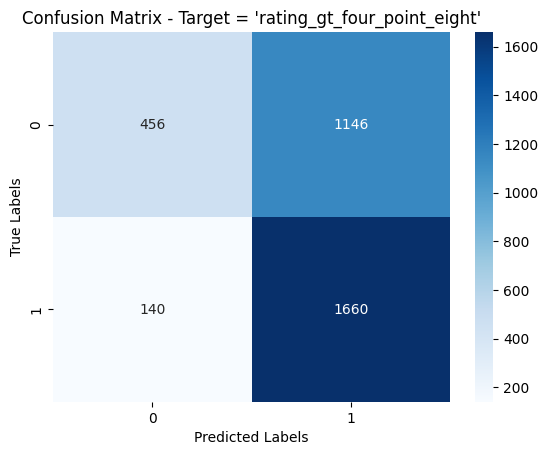

In [48]:
# Score the Model
xgb_classifier = evaluate_model_performance(best_params = best_params, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test, target='rating_gt_four_point_eight')

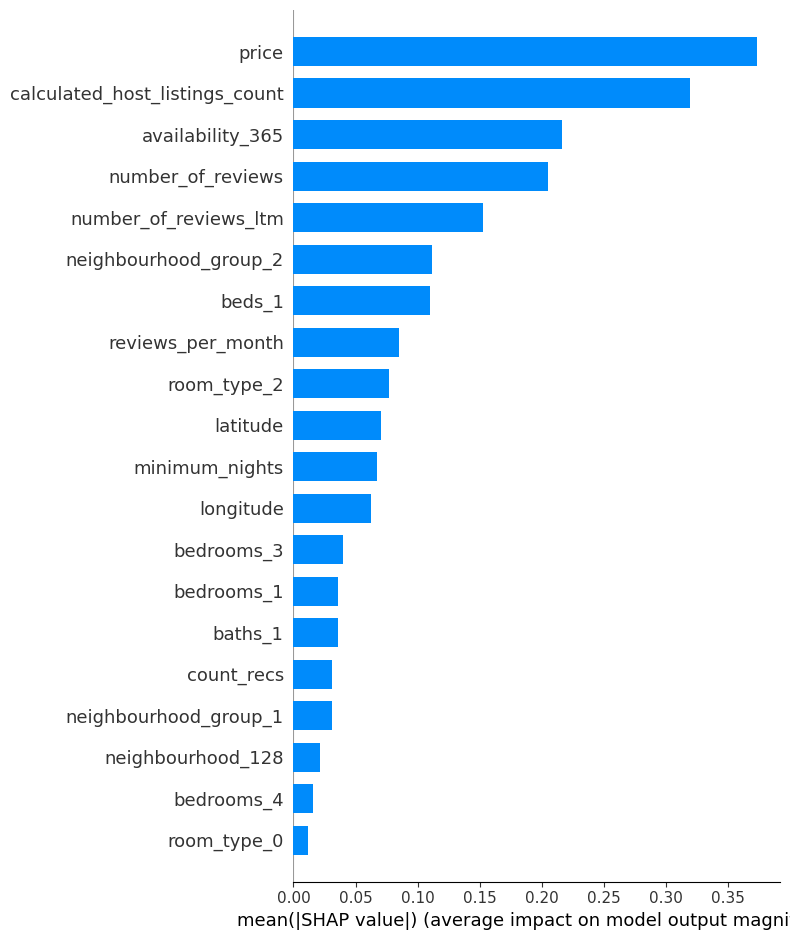

In [49]:
# Top Features
explainer = shap.TreeExplainer(xgb_classifier)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test, plot_type="bar")

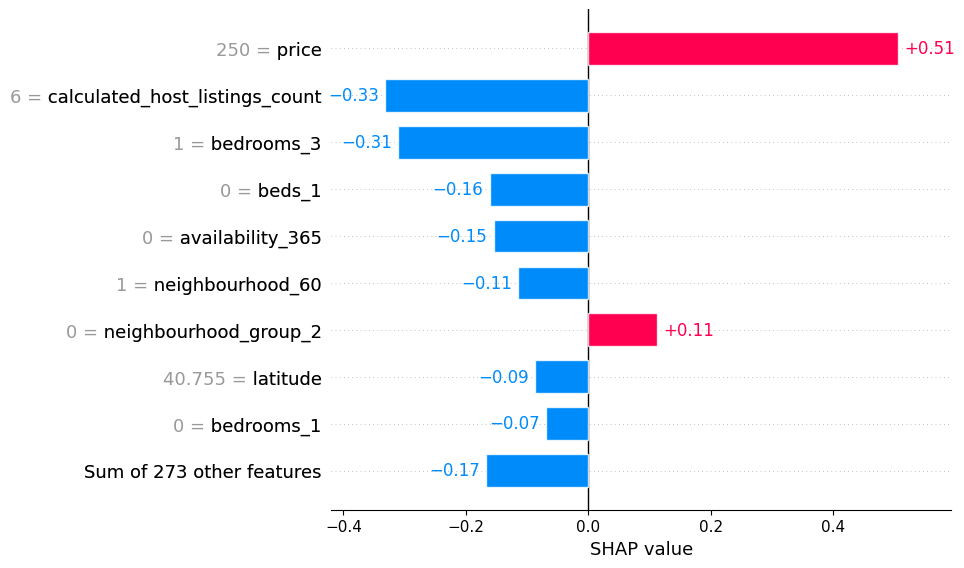

In [51]:
shap.plots.bar(shap_values = explainer(x_test)[0])

#### Lower the scale_pos_weight value in an attempt to reduce False Positives

In [52]:
adj_params = {'learning_rate': 0.2,
 'max_depth': 3,
 'n_estimators': 300,
 'reg_lambda': 0.5,
 'scale_pos_weight': 0.75}

Evaluation Metrics for XGboost model to predict Accounts with target='rating_gt_four_point_eight'; 
 Best Parameters used: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300, 'reg_lambda': 0.5, 'scale_pos_weight': 0.75}: 
 Accuracy: 0.659 
 Recall: 0.607 
 Precision: 0.707 
 F1-Score: 0.653


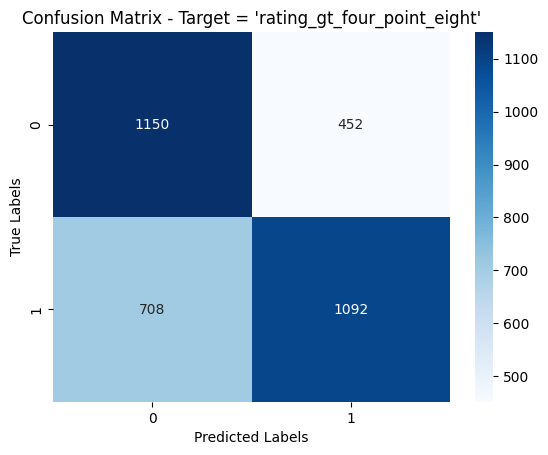

In [53]:
xgb_classifier = evaluate_model_performance(best_params = adj_params, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test, target='rating_gt_four_point_eight')

### Conclusion
* With resulting Accuracy = 62.2% and Recall = 92.2%, this model is effective at catching most of the Top Rated hosts, but also overdiagnoses leading to a high false positive rate (FP/(FP+TN)) = 1146/(1146+456) = 71.5%
* Reducing false positives will be difficult given the limited data scope and features
* However, it is impactful that we can achieve a F1 Score of 72.1% when predicting a high rated host (rating >= 4.8) given corresponding property features